In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
data = pd.read_csv("SIH Data.csv")
data['Day'] = data['Day'].ffill()

In [65]:
data.isnull().sum()

Day              0
Time             0
Temp           168
Rain(mm)       168
Gust(km/hr)    168
Rain%          168
IsHoliday        0
Load (MW)        0
dtype: int64

In [66]:
print("Column names:", data.columns)

data['Datetime'] = pd.to_datetime(data['Day'] + ' ' + data['Time'], format='%b-%d %H:%M')
data.set_index('Datetime', inplace=True)
data.drop(columns=['Day', 'Time'], inplace=True)
data = data.dropna(how='any',axis=0)
print("Column names:", data.columns)


Column names: Index(['Day', 'Time', 'Temp', 'Rain(mm)', 'Gust(km/hr)', 'Rain%', 'IsHoliday',
       'Load (MW)'],
      dtype='object')
Column names: Index(['Temp', 'Rain(mm)', 'Gust(km/hr)', 'Rain%', 'IsHoliday', 'Load (MW)'], dtype='object')


In [67]:
data

,Temp,Rain(mm),Gust(km/hr),Rain%,IsHoliday,Load (MW)
Datetime,,,,,,
1900-07-07 09:00:00,31.0,0.2,9.0,100.0,1,3983.84
1900-07-07 12:00:00,33.0,0.0,10.0,45.0,1,4877.60
1900-07-07 15:00:00,32.0,0.0,17.0,45.0,1,5278.73
1900-07-07 21:00:00,32.0,0.0,10.0,45.0,1,4973.65
1900-07-11 09:00:00,43.0,0.0,12.0,0.0,0,4983.46
...,...,...,...,...,...,...
1900-08-30 21:00:00,37.0,0.0,9.0,0.0,0,5570.15
1900-08-31 09:00:00,37.0,0.0,7.0,0.0,0,4613.17
1900-08-31 12:00:00,41.0,0.0,10.0,0.0,0,5595.74


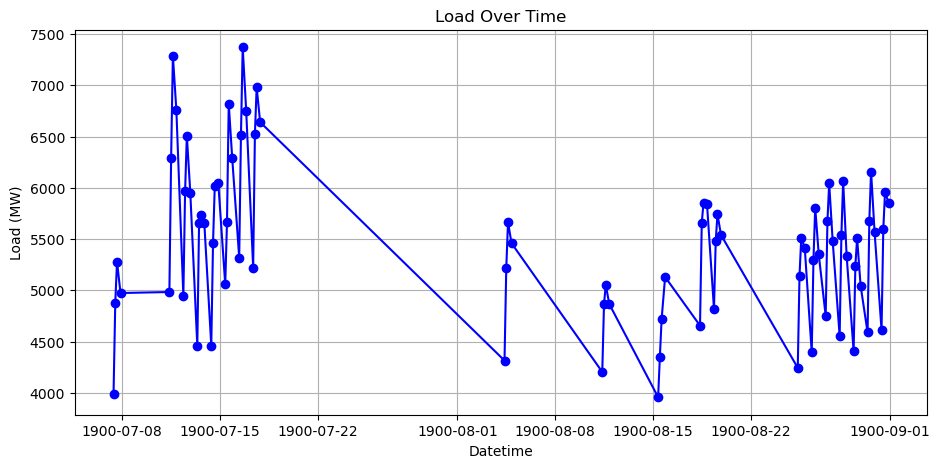

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 5))
plt.plot(data.index, data['Load (MW)'], marker='o', linestyle='-', color='b')
plt.title('Load Over Time')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.show()

In [69]:
data.head()

,Temp,Rain(mm),Gust(km/hr),Rain%,IsHoliday,Load (MW)
Datetime,,,,,,
1900-07-07 09:00:00,31.0,0.2,9.0,100.0,1,3983.84
1900-07-07 12:00:00,33.0,0.0,10.0,45.0,1,4877.60
1900-07-07 15:00:00,32.0,0.0,17.0,45.0,1,5278.73
1900-07-07 21:00:00,32.0,0.0,10.0,45.0,1,4973.65
1900-07-11 09:00:00,43.0,0.0,12.0,0.0,0,4983.46


In [70]:
train_size = 0.8  # 80% of data for training, 20% for testing
split_index = int(len(data) * train_size)

# Splitting the data chronologically
train, test = data[:split_index], data[split_index:]

print("Training data shape:", train.shape)
print("Testing data shape:", test.shape)

Training data shape: (64, 6)
Testing data shape: (16, 6)


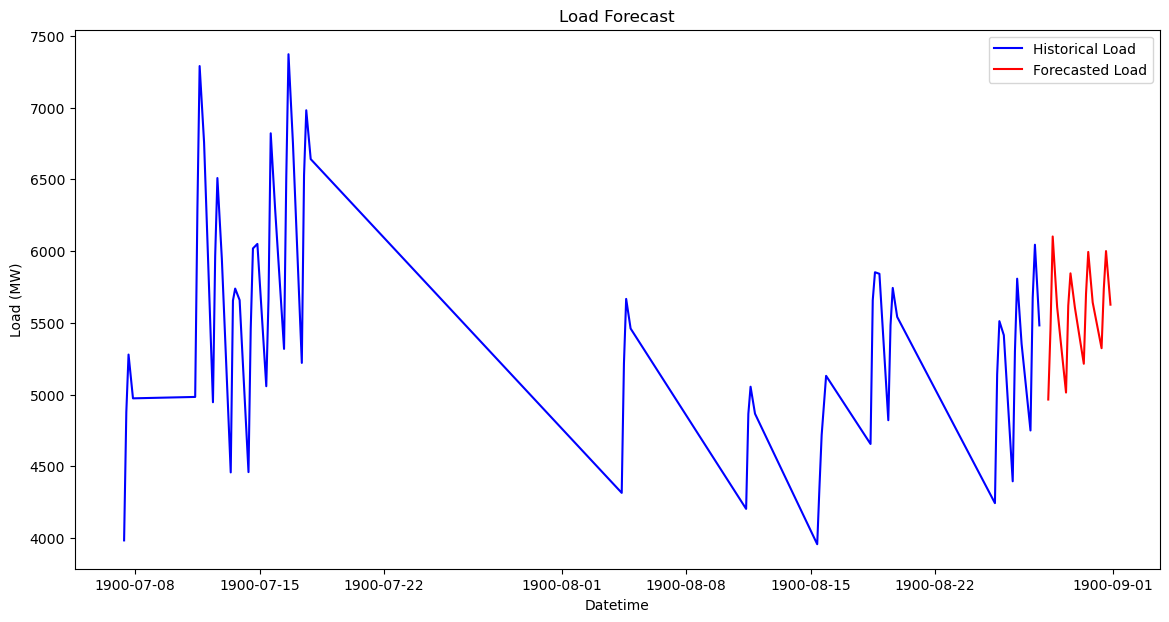

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create DataFrame
df = pd.DataFrame(data)

ts = train['Load (MW)']
exog_train = train[['Temp', 'Rain(mm)', 'Gust(km/hr)', 'Rain%', 'IsHoliday']]
exog_test = test[['Temp', 'Rain(mm)', 'Gust(km/hr)', 'Rain%', 'IsHoliday']]

model = SARIMAX(ts, exog=exog_train, order=(5, 1, 0))
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=len(test), exog=exog_test)
forecast_series = pd.Series(forecast.predicted_mean.values, index=test.index)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train['Load (MW)'], label='Historical Load', color='blue')
plt.plot(forecast_series, label='Forecasted Load', color='red')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.title('Load Forecast')
plt.legend()
plt.show()


Predicted        Actual          Error
4965.33 	 4553.19 	 412.14
5452.00 	 5540.36 	 88.36
6101.49 	 6069.53 	 31.96
5609.96 	 5335.68 	 274.28
5014.00 	 4407.91 	 606.09
5618.83 	 5239.42 	 379.41
5844.61 	 5510.95 	 333.66
5605.19 	 5045.18 	 560.01
5214.62 	 4589.81 	 624.81
5701.76 	 5678.58 	 23.18
5993.82 	 6158.84 	 165.02
5642.31 	 5570.15 	 72.16
5323.01 	 4613.17 	 709.84
5736.45 	 5595.74 	 140.71
5999.72 	 5961.56 	 38.16
5626.36 	 5854.81 	 228.45


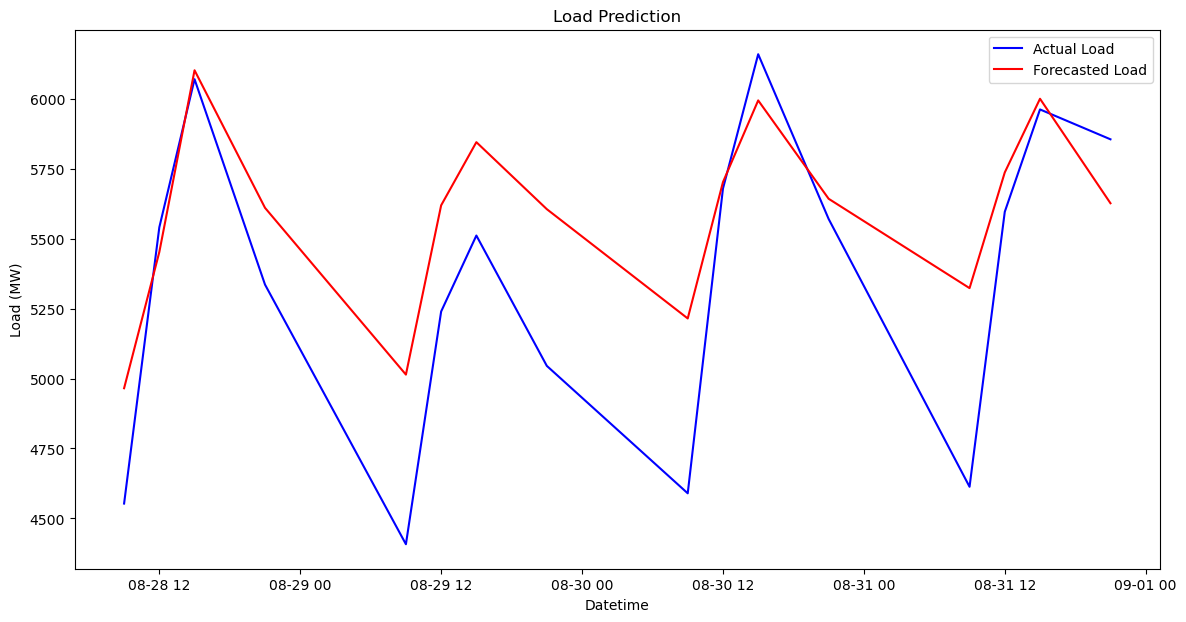

In [72]:
print('Predicted        Actual          Error')
for i,j in zip(forecast.predicted_mean.values, test['Load (MW)'].values):
    print(f"{i:.2f} \t {j:.2f} \t {abs(i-j):.2f}")

plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Load (MW)'].values, label='Actual Load', color='blue')
plt.plot(test.index, forecast.predicted_mean.values, label='Forecasted Load', color='red')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.title('Load Prediction')
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['Load (MW)'].values, forecast.predicted_mean.values)

print(f'MAE: {mae}')

MAE: 293.0153023589665
